# Cryptocurrency Portfolio Management with Diffusion Model
This project demonstrates how to combine a diffusion model and transfer model with cryptocurrency data and sentiment analysis to manage a portfolio using options. The code is split into different sections to facilitate understanding, from data loading and preprocessing to the portfolio value simulation and evaluation.

---
## Part 1: Data Loading and Preprocessing
This section loads the Bitcoin and Dogecoin datasets, as well as sentiment data related to each cryptocurrency. The data is loaded from CSV files via URLs. The timestamps are converted into datetime objects, and these are set as the index of the DataFrames. This step ensures that the data is time-aligned for analysis and modeling. The relevant columns (like closing price, high, low, open, volume) are selected to focus the analysis on the financial features that may affect cryptocurrency prices.

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
# Load data from URLs
btc_url = 'https://raw.githubusercontent.com/STATS201-DKU-Autumn2024/Problem_Set_1.Peilin_Wu/main/Data/bitcoin0.csv'
doge_url = 'https://raw.githubusercontent.com/STATS201-DKU-Autumn2024/Final-Project.Peilin_Wu/main/Data/dogecoin.csv'
btc_sentiment_url = 'https://raw.githubusercontent.com/STATS201-DKU-Autumn2024/Final-Project.Peilin_Wu/refs/heads/main/Data/multiTimelinebitcoin.csv'
doge_sentiment_url = 'https://raw.githubusercontent.com/STATS201-DKU-Autumn2024/Final-Project.Peilin_Wu/refs/heads/main/Data/multiTimeline%20dogecoin.csv'

# Read CSV files into DataFrames
btc_df = pd.read_csv(btc_url)
doge_df = pd.read_csv(doge_url)
btc_sentiment_df = pd.read_csv(btc_sentiment_url)
doge_sentiment_df = pd.read_csv(doge_sentiment_url)

# Convert timestamps to datetime format and set as DataFrame index
btc_df['time'] = pd.to_datetime(btc_df['time'], unit='ms')
btc_df.set_index('time', inplace=True)

doge_df['time'] = pd.to_datetime(doge_df['time'], unit='ms')
doge_df.set_index('time', inplace=True)

# Select relevant columns (price and volume data)
btc_df = btc_df[['close', 'high', 'low', 'open', 'volumefrom', 'volumeto']]
doge_df = doge_df[['close', 'high', 'low', 'open', 'volumefrom', 'volumeto']]

# Merge both dataframes on the timestamp (index)
combined_df = pd.merge(btc_df, doge_df, left_index=True, right_index=True, suffixes=('_btc', '_doge'))


### Key Concepts:

* Time Series Data: Both Bitcoin and Dogecoin price data are indexed by time.
* Data Selection: We're focused on financial features (closing prices, high, low, open prices, and volume).
* Data Merging: The two datasets are merged based on timestamps to analyze them together
---
## Part 2: Diffusion Model
This part defines the simple diffusion process applied to the data. A noise function is added to simulate the forward diffusion process, where random noise is introduced to the data. The denoising function is a basic reverse diffusion process where the noise is reduced by a scaling factor, simulating how the model reconstructs the data.

In [2]:
# 2. Define Diffusion Model (Simplified)

def add_noise_to_data(data, noise_factor=0.02):
    """ Add noise to the data to simulate forward diffusion process """
    noise = np.random.normal(loc=0, scale=noise_factor, size=data.shape)
    noisy_data = data + noise
    return noisy_data

def denoise_data(noisy_data, denoise_factor=0.8):
    """ Denoise the data (reverse diffusion) to simulate denoising process """
    return noisy_data * denoise_factor


### Key Concepts:

* Forward Diffusion: Adding noise represents the diffusion of information over time, which is typical in certain models (e.g., generative models).
* Reverse Diffusion: Denoising simulates the process of restoring the data by removing added noise, which is a basic approximation of the reverse diffusion step.
---
## Part 3: Data Scaling and Diffusion Simulation
Before feeding the data into any model, I normalize it using the MinMaxScaler from sklearn. This step ensures the data is on a consistent scale between 0 and 1, which is important for neural network convergence. After scaling, the noise is added (simulating diffusion) and then denoised, simulating the model learning to reverse the diffusion process.


In [3]:
# 3. Data Scaling and Diffusion Processing
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(combined_df)

# 3.1 Add noise to simulate the diffusion process
noisy_data = add_noise_to_data(scaled_data)

# 3.2 Perform denoising
denoised_data = denoise_data(noisy_data)


### Key Concepts:

* Data Normalization: Scaling ensures all features contribute equally to model learning.
* Diffusion Simulation: Adding and removing noise is a simplified approach to simulate a diffusion process that could be applied in more complex generative models.
---
## Part 4: Transformer Model Definition
The Transformer model is a type of neural network that handles sequential data. In this section, we define a basic Transformer architecture where the input data is passed through an embedding layer, followed by a series of Transformer Encoder layers. Positional encoding is used to preserve the order of the sequence. The model learns to map input sequences (prices) to output sequences (predictions).



In [4]:
# 4. Define Transformer Model

class TransformerModel(nn.Module):
    def __init__(self, input_dim, d_model=64, nhead=4, num_layers=3, dim_feedforward=128):
        super(TransformerModel, self).__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.positional_encoding = nn.Parameter(torch.zeros(1, 1, d_model))
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.output_layer = nn.Linear(d_model, input_dim)

    def forward(self, x):
        x = self.embedding(x)
        x += self.positional_encoding
        x = x.permute(1, 0, 2)  # Adjust dimensions for Transformer input
        x = self.transformer_encoder(x)
        x = x.permute(1, 0, 2)  # Restore original shape
        output = self.output_layer(x)
        return output


### Key Concepts:

* Embedding Layer: Converts input features into a higher-dimensional space suitable for the Transformer.
* Positional Encoding: Since Transformers don't inherently handle sequence order, we add positional encodings to retain temporal information.
* Transformer Encoder: A stack of layers that learns complex relationships between sequential data points (in this case, cryptocurrency prices).
* Output Layer: Maps the Transformer output back to the original feature space for predictions.
---
## Part 5: Model Training
In this section, we set up the training loop. The model is trained using the denoised data where X is the input sequence and y is the target sequence (shifted one step ahead). We use the Mean Squared Error (MSE) loss function to measure how well the model's predictions match the true data.

In [5]:
# 5. Model Training

input_dim = denoised_data.shape[1]
transformer_model = TransformerModel(input_dim=input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(transformer_model.parameters(), lr=0.001)

# Prepare training data
X = torch.tensor(denoised_data[:-1], dtype=torch.float32).unsqueeze(0)  # Add batch dimension
y = torch.tensor(denoised_data[1:], dtype=torch.float32).unsqueeze(0)

epochs = 100
for epoch in range(epochs):
    transformer_model.train()
    optimizer.zero_grad()
    outputs = transformer_model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch {epoch + 1}/{epochs}, Loss: {loss.item():.4f}')


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 10/100, Loss: 0.0372
Epoch 20/100, Loss: 0.0223
Epoch 30/100, Loss: 0.0164
Epoch 40/100, Loss: 0.0122
Epoch 50/100, Loss: 0.0096
Epoch 60/100, Loss: 0.0083
Epoch 70/100, Loss: 0.0075
Epoch 80/100, Loss: 0.0068
Epoch 90/100, Loss: 0.0060
Epoch 100/100, Loss: 0.0055


### Key Concepts:

* Training Data Preparation: I use the denoised data for training, where each time step's value is used to predict the next one.
* Backpropagation: The loss is calculated and the model weights are updated using backpropagation and the Adam optimizer.
* Epochs: I train for 100 epochs, adjusting the model after each pass through the data.
---
## Part 6: Portfolio Management and Option Simulation
In this section, we simulate the management of a cryptocurrency portfolio. The model's predictions about Bitcoin and Dogecoin price changes are used to update the portfolio's asset holdings and option positions. The portfolio is assumed to have an initial capital of $10,000, and positions in Bitcoin and Dogecoin are adjusted based on the predicted price changes.

The simulated options behave in an inverse relationship to price changes (this is a simplification). Each time step, the model makes predictions on how the price of Bitcoin and Dogecoin changes, and based on this, the portfolio is updated. The value of the portfolio is then tracked over time.



In [6]:
# 6. Portfolio Management and Option Simulation

initial_capital = 10000
btc_position = 0
doge_position = 0
btc_option_position = 0
doge_option_position = 0

# Simulated option price changes
def get_option_price_change(price_change):
    return -price_change

# Store portfolio values
portfolio_values = []

for i in range(1, len(denoised_data)):
    predicted_btc_change = denoised_data[i][0] - denoised_data[i - 1][0]
    predicted_doge_change = denoised_data[i][1] - denoised_data[i - 1][1]

    btc_option_change = get_option_price_change(predicted_btc_change)
    doge_option_change = get_option_price_change(predicted_doge_change)

    if predicted_btc_change > 0:
        btc_position = initial_capital * 0.5 / combined_df['close_btc'][i]
        btc_option_position = btc_position * btc_option_change
    else:
        btc_option_position = initial_capital * 0.5 / combined_df['close_btc'][i]

    if predicted_doge_change > 0:
        doge_position = initial_capital * 0.5 / combined_df['close_doge'][i]
        doge_option_position = doge_position * doge_option_change
    else:
        doge_option_position = initial_capital * 0.5 / combined_df['close_doge'][i]

    portfolio_value = (btc_position * combined_df['close_btc'][i] +
                       doge_position * combined_df['close_doge'][i] +
                       btc_option_position + doge_option_position)
    portfolio_values.append(portfolio_value)

# Convert portfolio values to DataFrame and handle mismatched lengths
portfolio_df = pd.DataFrame(portfolio_values, columns=['Portfolio Value'])
portfolio_df['Date'] = combined_df.index[1:len(portfolio_values) + 1]
portfolio_df.set_index('Date', inplace=True)


<ipython-input-6-effbdcb5b3a5>:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  btc_option_position = initial_capital * 0.5 / combined_df['close_btc'][i]
<ipython-input-6-effbdcb5b3a5>:33: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  doge_option_position = initial_capital * 0.5 / combined_df['close_doge'][i]
<ipython-input-6-effbdcb5b3a5>:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  portfolio_value = (btc_position * combined_

### Key Concepts:

* Initial Capital: The portfolio starts with $10,000, split between Bitcoin and Dogecoin positions and options.
* Predicted Price Changes: The model predicts how the price of each cryptocurrency changes from one time step to the next.
* Options Simulation: An option is assumed to change in value inversely to the price of the underlying asset (this is a simplification of real-world options behavior).
* Portfolio Value Calculation: The total portfolio value is calculated by summing the value of the cryptocurrency positions and options.
---
## Part 7: Plotting Portfolio Value Showing
After calculating the portfolio's value over time, I visualize the result using matplotlib. This allows us to track how the portfolio performs, based on the model's predictions of cryptocurrency price changes and option trading.


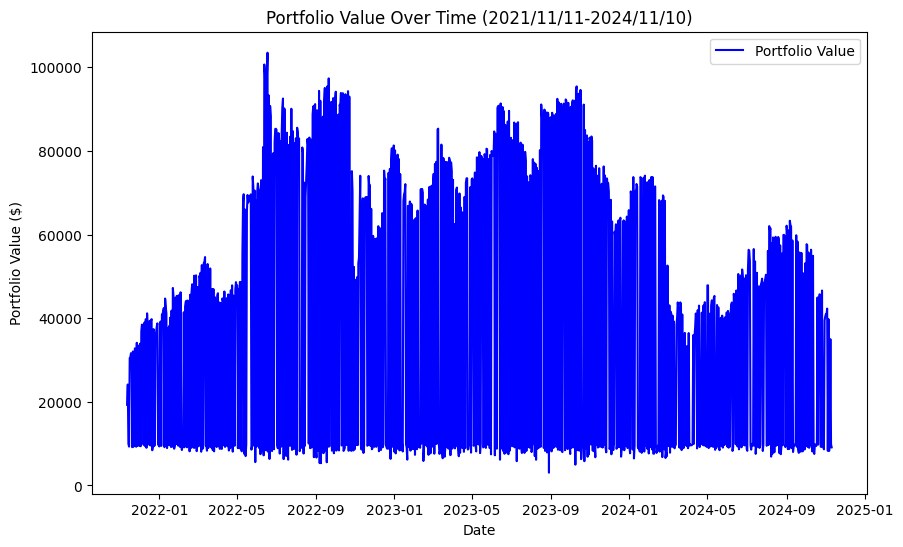

In [7]:
# 7. Plot Portfolio Value

plt.figure(figsize=(10, 6))
plt.plot(portfolio_df.index, portfolio_df['Portfolio Value'], label='Portfolio Value', color='blue')
plt.title('Portfolio Value Over Time (2021/11/11-2024/11/10)')
plt.xlabel('Date')
plt.ylabel('Portfolio Value ($)')
plt.legend()
plt.show()


### Key Concepts:

* Visualization: The plot helps to track how the portfolio grows or shrinks over time, allowing the user to evaluate the effectiveness of the model's trading strategy.
* Performance Evaluation: By looking at the graph, you can assess whether the model's predictions are improving the portfolio value over time.
---
## Part 8: Model Evaluation: MSE, MAE, R²
Finally, we evaluate the performance of the model by calculating common regression metrics: Mean Squared Error (MSE), Mean Absolute Error (MAE), and R² (Coefficient of Determination). These metrics are useful to understand how well the model's predictions align with the true data.

In [8]:
# Calculate MSE, MAE, and R²
y_true = denoised_data[1:]  # True values (denoised data from time step 1 onward)
y_pred = denoised_data[:-1]  # Predicted values (denoised data from time step 0 onward)

# Compute performance metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f'MSE: {mse:.4f}')
print(f'MAE: {mae:.4f}')
print(f'R²: {r2:.4f}')


MSE: 0.0018
MAE: 0.0282
R²: 0.7996


### Key Concepts:

* MSE (Mean Squared Error): Measures the average squared difference between the predicted and actual values. Lower values indicate better predictions.
* MAE (Mean Absolute Error): Measures the average absolute difference between the predicted and actual values. Like MSE, lower values are better.
* R² (R-Squared): Represents how much variance in the actual data is explained by the model. Higher values indicate better explanatory power.
---
## Summary of Key Parts
1. Data Loading and Preprocessing: Loading and merging cryptocurrency price data, followed by time-based indexing and column selection.
2. Diffusion Model: A simplified forward and reverse diffusion process (noise addition and denoising) to simulate data transformation.
3. Transformer Model: A deep learning model designed for sequential data that uses attention mechanisms to learn from temporal relationships in the data.
4. Model Training: Training the Transformer model with the denoised data to predict future cryptocurrency prices.
5. Portfolio Management and Options: Simulating cryptocurrency trading with portfolio management and option simulation based on predicted price changes.
6. Portfolio Visualization: Plotting the value of the portfolio over time to assess the performance of the trading strategy.
7. Model Evaluation: Evaluating the model’s prediction performance using MSE, MAE, and R² metrics.